**Digital tree/ Trie implementation and test on cities.csv dataset**

In [1]:
from time import time
import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def random_feed_id(l_cities, stringLength=60, proba_city = 0.75):
    """Generate a random string of fixed length, with a probability of proba_city of having the name of a city"""
    letters = string.ascii_lowercase
    my_str = ''.join(random.choice(letters) for i in range(stringLength))
    yes = False
    if random.random() > proba_city:
        city = l_cities[int(random.random()*len(l_cities))]
        beg = int(random.random()*(30-len(city)))
        my_str = my_str[:beg] + city +  my_str[beg+len(city)]
        yes = True
    return my_str

csv = pd.read_csv('cities.csv')
# In order to test my functions, I use the cities.csv from https://datahub.io/core/world-cities "world cities"
l_cities = csv['name'].tolist()
l_feed_ids = []
for i in range(5000):
    l_feed_ids.append(random_feed_id(l_cities))

### 1 - Naive function :

Complexity : O(number of feed_ids * number of cities *  average length of a feed_id) : Indeed, we have two "for" loops, and "if city in feed_id"  has a complexity in average of O(N), where N is the len of a feed_id

In [3]:
def detect_city_name_naive(l_cities, l_feed_ids):
    l_feed_id_with_city_names_naive = []
    for feed_id in l_feed_ids:
        for city in l_cities:
            if city in feed_id:
                l_feed_id_with_city_names_naive.append(feed_id)
                break
    return l_feed_id_with_city_names_naive

beg = time()
l_feed_id_with_city_names_naive = detect_city_name_naive(l_cities, l_feed_ids)
print('Time :', time() - beg, 's')

Time : 12.008142471313477 s


### 2 - Trie Class :
#### 2.a :

In [4]:
class TrieNode():
    def __init__(self, char):
        self.char = char
        self.children = []
        self.word_finished = False
        self.counter = 1
    
    def child_char(self, char):
        for child in self.children:
            if char == child.char:
                return child
        return False

class Trie(): 
    def __init__(self, char = ''):
        self.root = TrieNode(char)
        self.char_explore = self.root
    
    def add(self, word):
        node = self.root
        for char in word:
            found_in_child = False
            for child in node.children:
                if child.char == char:
                    child.counter += 1
                    node = child
                    found_in_child = True
                    break
            if not found_in_child:
                new_node = TrieNode(char)
                node.children.append(new_node)
                node = new_node
        node.word_finished = True

    def find(self, prefix: str):
        node = self.root
        if not node.children:
            return False, 0
        for char in prefix:
            char_not_found = True
            for child in node.children:
                if child.char == char:
                    char_not_found = False
                    node = child
                    break
            if char_not_found:
                return False, 0
        return True, node.counter

#### 2.b :
Construction of the trie :

In [5]:
new_trie = Trie()
for city in l_cities:
    new_trie.add(city)

The complexity of adding a new word in the trie can be very variable, as we may have to browse all the child characters of a character, or go to the first.
And we may need to add a new node for each character in the word, or a new character only for the last character / leaf. According to the publications, the complexity of building a sort of n words is O (n), we can verify this:

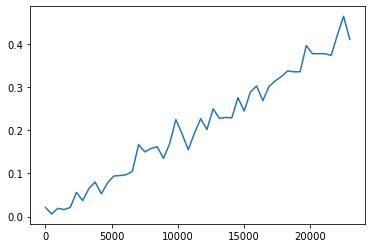

In [6]:
l_time = []
for i in np.linspace(0, len(l_cities), 50):
    subl_cities = l_cities[:int(i)]
    beg = time()
    new_trie = Trie()
    for city in subl_cities:
        new_trie.add(city)
    l_time.append(time() - beg)
    
plt.plot(np.linspace(0, len(l_cities), 50), l_time)

It seems linear. We can imaging that it depends also of the mean of number of char in the words, and that long words increase complexity

#### 2.c :

In [7]:
def detect_city_name_trie(trie, l_feed_ids):
    l_feed_id_with_city_names_trie = []
    for feed_id in l_feed_ids:
        include_city_name = False
        l_nodes = []
        for char in feed_id:
            l_nodes.append(trie.root)
            l_sauv = []
            for ind, node in enumerate(l_nodes):
                child = node.child_char(char)
                if child:
                    l_nodes[ind] = child
                    l_sauv.append(child)
                    if child.word_finished:
                            l_feed_id_with_city_names_trie.append(feed_id)
                            include_city_name = True
                            break
            if include_city_name:
                break
            l_nodes = l_sauv
    return l_feed_id_with_city_names_trie


beg = time()
l_feed_id_with_city_names_trie = detect_city_name_trie(new_trie, l_feed_ids)
print('Time :', time() - beg, 's')

Time : 1.7712340354919434 s


Complexity in O(nb of feed_ids * average len of feed_id * average number of child per node)

In [8]:
# We verify that the two lists are the sames
l_feed_id_with_city_names_naive == l_feed_id_with_city_names_trie

True

### Unit tests : 

In [9]:
one_word_trie = Trie()
one_word_trie.add('london')

print(detect_city_name_trie(one_word_trie, ['aaaaaaaaaaaaaaaa', 'aaaaaalondonaaaa', 'aaaaaaaaaalondon', 'londonaaaaaaaaaa']))

print(one_word_trie.find('london'))
print(one_word_trie.find('berlin'))

['aaaaaalondonaaaa', 'aaaaaaaaaalondon', 'londonaaaaaaaaaa']
(True, 1)
(False, 0)
